In [34]:
import numpy as np
from sklearn.datasets import load_breast_cancer
import cvxopt.solvers
import logging
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [10]:
def linear(x, y):
    return np.inner(x, y)

In [150]:
data = load_breast_cancer()
X = data.data
y = data.target
X.shape, y.shape

((569, 30), (569,))

In [138]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

(455, 30) (114, 30) (455,) (114,)
(455, 455)
(1, 455)
170 support vectors out of 455 points
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0


/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


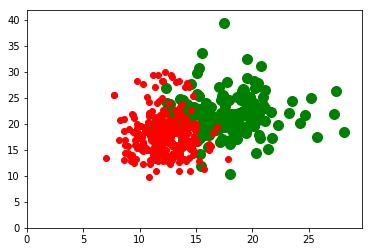

In [160]:
import numpy as np
from numpy import linalg
from sklearn.preprocessing import normalize
import cvxopt
import cvxopt.solvers
             
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

class SVM(object):

    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples), 'd')
        print(np.matrix(np.outer(y,y) * K).shape)
        print(np.matrix(np.ones(n_samples) * -1).shape)
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print("%d support vectors out of %d points" % (len(self.a), n_samples))

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            print(self.b)
            print(np.sum(self.a * self.sv_y * K[ind[n],sv]))
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv], dtype=np.int64)
        self.b = self.b / len(self.a)

        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

    def project(self, X):
        if self.w is not None:
            if X.shape[1]==2:
                w = self.w[:2]
            else:
                w = self.w
            return np.dot(X, w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

if __name__ == "__main__":
    import pylab as pl

    def plot_margin(X1_train, X2_train, clf):
        def f(x, w, b, c=0):
            # given x, return y such that [x,y] in on the line
            # w.x + b = c
            return (-w[0] * x - b + c) / w[1]

        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

        # w.x + b = 0
        a0 = -4; a1 = f(a0, clf.w, clf.b)
        b0 = 4; b1 = f(b0, clf.w, clf.b)
        pl.plot([a0,b0], [a1,b1], "k")

        # w.x + b = 1
        a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
        pl.plot([a0,b0], [a1,b1], "k--")

        # w.x + b = -1
        a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
        pl.plot([a0,b0], [a1,b1], "k--")

        pl.axis("tight")
        pl.show()

    def plot_contour(X1_train, X2_train, clf):
        X0, X1 = X[:, 0], X[:, 1]
        xx, yy = make_meshgrid(X0, X1)

        plot_contours(clf, xx, yy,
                          cmap=plt.cm.coolwarm, alpha=0.8)
        ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)

    def test_soft():
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
        clf = SVM(C=1000.1)
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))
        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)
        plt.show()
        
    def make_meshgrid(x, y, h=.02):
        """Create a mesh of points to plot in

        Parameters
        ----------
        x: data to base x-axis meshgrid on
        y: data to base y-axis meshgrid on
        h: stepsize for meshgrid, optional

        Returns
        -------
        xx, yy : ndarray
        """
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        return xx, yy


    def plot_contours(clf, xx, yy, **params):
        """Plot the decision boundaries for a classifier.

        Parameters
        ----------
        ax: matplotlib axes object
        clf: a classifier
        xx: meshgrid ndarray
        yy: meshgrid ndarray
        params: dictionary of params to pass to contourf, optional
        """
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        out = ax.contourf(xx, yy, Z, **params)
        return out
        
    test_soft()

mysvm weights: [-0.45524179 -0.09999388  8.84448563]
sklearn weights: [[-0.69566917 -0.13386799]] intercept: [12.93093297]
mysvm predict: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
sklearn predict: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
-0.4552417902590714 6.981 28.11


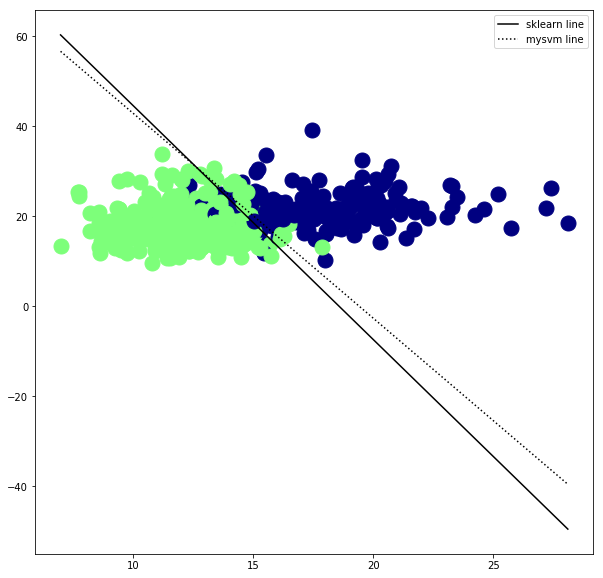

In [271]:
import numpy as np
from scipy import optimize

class SVM2C:
    def __init__(self,x,y,c=5,learning_rate=0.001,
            n_iter=100000,method='GD'):

        self.values=np.unique(y)
        # Add 1 dimension for bias
        self.x=np.hstack([x,np.ones([x.shape[0],1])])
        self.y=np.where(y==self.values[-1],1,-1)
        self.c=c
        self.lr=learning_rate
        self.n_iter=n_iter
        self.method=method

        self.m=len(x)
        self.w=np.random.random(self.x.shape[1])-0.5

    def costFunc(self):
        xw=np.dot(self.x,self.w)
        j=np.maximum(0.,1.-self.y*xw).mean()*self.c+0.5*np.sum(self.w[:-1]**2)
        return j

    def J(self):
        '''Derivative of cost function'''
        xw=np.dot(self.x,self.w)
        I=np.where(self.y*xw>=1.,0.,-self.y)[:,None]
        dj=np.zeros(self.w.shape)
        dj[:-1]=(I*self.x[:,:-1]).mean(axis=0)*self.c+self.w[:-1] # weights
        dj[-1]=(I*self.c).mean(axis=0)                      # bias
        return dj

    def train(self):

        #----------Optimize using scipy.optimize----------
        if self.method=='optimize':
            opt=optimize.minimize(self.costFunc,self.w,args=(self.x,self.y),\
                    J=self.J,method='BFGS')
            self.w=opt.x

        #---------Optimize using Gradient descent---------
        elif self.method=='GD':
            costs=[]
            for _ in range(self.n_iter):
                dj=self.J()
                self.w=self.w-self.lr*dj
                ci=self.costFunc()
                costs.append(ci)

            self.costs=np.array(costs)

        return self


    def predict(self,x):
        x = np.hstack([x,np.ones([x.shape[0],1])])
        y_preds=[]
        for i in x:
            y_pred=np.sign(i.dot(self.w))
            y_pred=self.values[-1] if y_pred>=0 else self.values[0]
            y_preds.append(y_pred)
        y_preds=np.array(y_preds)

        return y_preds

if __name__=='__main__':

    from sklearn import datasets
    cancer=datasets.load_breast_cancer()
    x=cancer.data[:,:2]
    y=cancer.target


    #----------------------Train----------------------
    mysvm=SVM2C(x,y,method='GD')
    mysvm.train()

    ntest=20
    xtest=2*(np.random.random([ntest,2])-0.5)+x.mean(axis=0)

    from sklearn import svm
    clf=svm.SVC(C=50,kernel='linear')
    clf.fit(x,y)

    y_preds=mysvm.predict(xtest)
    y_preds2=clf.predict(xtest)

    print('mysvm weights:', mysvm.w)
    print('sklearn weights:', clf.coef_, 'intercept:', clf.intercept_)
    print('mysvm predict:', y_preds)
    print('sklearn predict:',y_preds2)

    #-------------------Plot------------------------
    import matplotlib.pyplot as plt
    figure=plt.figure(figsize=(10,10))
    ax=figure.add_subplot(111)

    cmap=plt.cm.jet
    nclasses=np.unique(y).tolist()
    colors=[cmap(float(i)/len(nclasses)) for i in nclasses]

    #----------------Plot training data----------------
    for i in range(len(y)):
        xi=x[i][0]
        yi=x[i][1]
        colori=colors[nclasses.index(y[i])]
        ax.plot(xi,yi,color=colori,marker='o',markersize=15)

    #------------------Plot test data------------------
    for i in range(ntest):
        colori=colors[nclasses.index(y_preds2[i])]
        ax.plot(xtest[i][0],xtest[i][1],color=colori,marker='^',markersize=5)

    #--------------------Plot line--------------------
    x1=x[:,0].min()
    x2=x[:,0].max()

    y1=(-clf.intercept_-clf.coef_[0][0]*x1)/clf.coef_[0][1]
    y2=(-clf.intercept_-clf.coef_[0][0]*x2)/clf.coef_[0][1]
    
    y3=(-mysvm.w[-1]-mysvm.w[0]*x1)/mysvm.w[1]
    y4=(-mysvm.w[-1]-mysvm.w[0]*x2)/mysvm.w[1]
    print(mysvm.w[0], x1,x2)
    
    ax.plot([x1,x2],[y1,y2],'-k',label='sklearn line')
    ax.plot([x1,x2],[y3,y4],':k',label='mysvm line')
    ax.legend(loc=0)
    plt.show(block=False)